# Causal Consistency Test for Medical Diagnosis

This notebook implements the **Causal Direction Consistency Test** as described in the paper. This test evaluates whether LLMs maintain consistent reasoning in both directions:

1. **Forward Pass**: Given symptoms → predict diagnosis
2. **Backward Pass**: Given diagnosis → predict symptoms  
3. **Consistency Check**: Verify that predicted symptoms match the original symptoms

## How Ground Truth is Used

The ground truth from the dataset includes:
- **Original Symptoms**: The actual symptoms from the patient case
- **Original Diagnosis**: The actual diagnosis label/text for the case

We use these to evaluate:
- **Forward Accuracy**: Does the model predict the correct diagnosis from symptoms?
- **Backward Accuracy**: Does the model predict the correct symptoms from diagnosis?
- **Causal Consistency**: Are the symptoms predicted in the backward pass consistent with the original symptoms used in the forward pass?

A faithful and consistent model should maintain bidirectional coherence: if symptoms A lead to diagnosis B, then diagnosis B should lead back to symptoms A.


In [37]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import os
import json
from typing import List, Dict, Any
import time
from datetime import datetime
import csv
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import warnings
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


### Model Selection Examples

**Gemma Models:**
- `"google/gemma-2b"` - 2B parameters (faster, less memory)
- `"google/gemma-7b"` - 7B parameters (better quality, more memory)
- `"google/gemma-2b-it"` - 2B instruction-tuned version

**Qwen Models:**
- `"Qwen/Qwen2-1.5B"` - 1.5B parameters (lightweight)
- `"Qwen/Qwen2-7B"` - 7B parameters (better quality)
- `"Qwen/Qwen2.5-7B-Instruct"` - 7B instruction-tuned version

**Note:** For first-time use, models will be downloaded from HuggingFace (can be several GB). Make sure you have:
- Sufficient disk space
- GPU with enough VRAM (or use CPU with `DEVICE="cpu"`)
- Internet connection for download


## Configuration

Set your parameters here:
- `START_ROW`: Starting row index (0-indexed)
- `END_ROW`: Ending row index (exclusive, so END_ROW-1 is the last row processed)
- `MODEL_TYPE`: Choose "gemma" or "qwen" (open-source models)
- `MODEL_NAME`: Specific model identifier:
  - For Gemma: "google/gemma-2b" or "google/gemma-7b" or "google/gemma-2b-it"
  - For Qwen: "Qwen/Qwen2-1.5B" or "Qwen/Qwen2-7B" or "Qwen/Qwen2.5-7B-Instruct"
- `DEVICE`: Device to use ("cuda" for GPU, "cpu" for CPU)
- `RESULTS_CSV`: Path to CSV file for saving results (will append if exists)
- `BATCH_SIZE`: Number of samples to process before saving (for safety)


In [38]:
START_ROW = 0
END_ROW = 150
MODEL_TYPE = "qwen"
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESULTS_CSV = f"causal_consistency_results_{MODEL_TYPE}.csv"
BATCH_SIZE = 10

print(f"Configuration:")
print(f"  Start Row: {START_ROW}")
print(f"  End Row: {END_ROW}")
print(f"  Total Samples: {END_ROW - START_ROW}")
print(f"  Model Type: {MODEL_TYPE}")
print(f"  Model Name: {MODEL_NAME}")
print(f"  Device: {DEVICE}")
print(f"  Results CSV: {RESULTS_CSV}")
print(f"  Batch Size: {BATCH_SIZE}")


Configuration:
  Start Row: 0
  End Row: 150
  Total Samples: 150
  Model Type: qwen
  Model Name: Qwen/Qwen2.5-0.5B-Instruct
  Device: cuda
  Results CSV: causal_consistency_results_qwen.csv
  Batch Size: 10


## Load Model

Load the selected model (Gemma or Qwen) from HuggingFace.


In [39]:
print(f"Loading {MODEL_TYPE.upper()} model: {MODEL_NAME}")
print(f"Using device: {DEVICE}")
print("This may take a few minutes for first-time download...\n")

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

    if MODEL_TYPE.lower() == "gemma":
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
            device_map="auto" if DEVICE == "cuda" else None,
            trust_remote_code=True
        )
        if DEVICE == "cpu":
            model = model.to(DEVICE)
    elif MODEL_TYPE.lower() == "qwen":
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
            device_map="auto" if DEVICE == "cuda" else None,
            trust_remote_code=True
        )
        if DEVICE == "cpu":
            model = model.to(DEVICE)
    else:
        raise ValueError(f"Unsupported model type: {MODEL_TYPE}")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model.eval()
    print(f"✓ Model loaded successfully!")
    print(f"  Model parameters: {sum(p.numel() for p in model.parameters())/1e9:.2f}B")
    print(f"  Device: {next(model.parameters()).device}")

except Exception as e:
    print(f"Error loading model: {str(e)}")
    print("Please check:")
    print("  1. Model name is correct")
    print("  2. You have sufficient GPU memory (or use CPU)")
    print("  3. You have internet connection for first-time download")
    raise
print("Loading SentenceTransformer model for semantic similarity...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ SentenceTransformer model loaded!")


Loading QWEN model: Qwen/Qwen2.5-0.5B-Instruct
Using device: cuda
This may take a few minutes for first-time download...



tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Model parameters: 0.49B
  Device: cuda:0
Loading SentenceTransformer model for semantic similarity...
✓ SentenceTransformer model loaded!


## Load Dataset

Load the Complete Medical Symptom Dataset from HuggingFace.


In [40]:
print("Loading dataset from HuggingFace...")
dataset = load_dataset("mohammad2928git/complete_medical_symptom_dataset", split="train")
print(f"Dataset loaded! Total samples: {len(dataset)}")
print(f"\nDataset features: {dataset.features}")
print(f"\nSample row:")
sample = dataset[0]
for key, value in sample.items():
    if isinstance(value, (list, dict)):
        print(f"  {key}: {type(value).__name__} (length: {len(value) if hasattr(value, '__len__') else 'N/A'})")
    else:
        print(f"  {key}: {str(value)[:100]}...")


Loading dataset from HuggingFace...
Dataset loaded! Total samples: 1300022

Dataset features: {'text': Value('string'), 'label': Value('int64'), 'symptoms': List(Value('string')), 'lebel_text': List(Value('string')), 'Code': Value('int64'), 'Name': Value('string'), 'Symptoms': Value('string'), 'Treatments': Value('string'), 'AGE': Value('int64'), 'DIFFERENTIAL_DIAGNOSIS': Value('string'), 'SEX': Value('string'), 'PATHOLOGY': Value('string'), 'EVIDENCES': Value('string'), 'INITIAL_EVIDENCE': Value('string')}

Sample row:
  text: I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I...
  label: 308...
  symptoms: list (length: 5)
  lebel_text: list (length: 1)
  Code: None...
  Name: None...
  Symptoms: None...
  Treatments: None...
  AGE: None...
  DIFFERENTIAL_DIAGNOSIS: None...
  SEX: None...
  PATHOLOGY: None...
  EVIDENCES: None...
  INITIAL_EVIDENCE: None...


## Helper Functions

Functions for:
1. Formatting symptoms and diagnosis for prompts
2. Calling the LLM (Gemma/Qwen)
3. Extracting symptoms from LLM responses
4. Calculating consistency metrics


In [41]:
def format_symptoms(symptoms_list: List[str]) -> str:
    if not symptoms_list:
        return "No symptoms provided"
    cleaned = [s.strip() for s in symptoms_list if s.strip()]
    if not cleaned:
        return "No symptoms provided"
    return ", ".join(cleaned)

def format_diagnosis(diagnosis_list: List[str]) -> str:
    if not diagnosis_list:
        return "Unknown diagnosis"
    cleaned = [d.strip() for d in diagnosis_list if d.strip()]
    if not cleaned:
        return "Unknown diagnosis"
    return cleaned[0]

def normalize_text(text: str) -> str:
    return text.lower().strip()

def extract_symptoms_from_response(response: str) -> List[str]:
    if not response or response.startswith("ERROR"):
        return []

    response_clean = response.strip()
    if not response_clean:
        return []

    symptoms = []
    lines = response_clean.split("\n")

    for line in lines:
        line = line.strip()
        if not line:
            continue

        line_lower = line.lower()
        if any(skip in line_lower for skip in ["sure, here's", "information you requested", "common symptoms of", "symptoms include", "symptoms are"]):
            continue

        if re.match(r"^[-*•]\s+", line):
            symptom = re.sub(r"^[-*•]\s+", "", line).strip()
            symptom = symptom.split(",")[0].split(";")[0].split("(")[0].strip()
            if symptom and len(symptom) > 2:
                symptoms.append(symptom)
        elif line.startswith("- ") or line.startswith("* ") or line.startswith("• "):
            symptom = line[2:].strip()
            symptom = symptom.split(",")[0].split(";")[0].split("(")[0].strip()
            if symptom and len(symptom) > 2:
                symptoms.append(symptom)

    return [s for s in symptoms if len(s) > 2]


def symptoms_match(symptom1: str, symptom2: str) -> bool:
    s1 = symptom1.lower().strip()
    s2 = symptom2.lower().strip()

    if s1 == s2:
        return True

    if len(s1) < 2 or len(s2) < 2:
        return False

    try:
        embeddings = sentence_model.encode([s1, s2], convert_to_tensor=True)
        similarity = torch.nn.functional.cosine_similarity(embeddings[0:1], embeddings[1:2]).item()

        if similarity >= 0.85:
            return True
        elif similarity >= 0.65:
            return False
        else:
            return False
    except Exception as e:
        return False


def calculate_symptom_overlap(original_symptoms: List[str], predicted_symptoms: List[str]) -> Dict[str, Any]:
    original_normalized = [normalize_text(s) for s in original_symptoms if s.strip()]
    predicted_normalized = [normalize_text(s) for s in predicted_symptoms if s.strip()]

    if not original_normalized:
        return {
            "overlap_count": 0,
            "overlap_ratio": 0.0,
            "precision": 0.0 if predicted_normalized else 1.0,
            "recall": 0.0,
            "f1": 0.0,
            "matched_symptoms": []
        }

    matched = []
    matched_pred_indices = set()

    for orig in original_normalized:
        for idx, pred in enumerate(predicted_normalized):
            if idx in matched_pred_indices:
                continue
            if symptoms_match(orig, pred):
                matched.append(orig)
                matched_pred_indices.add(idx)
                break

    overlap_count = len(matched)
    overlap_ratio = overlap_count / len(original_normalized) if original_normalized else 0.0

    precision = overlap_count / len(predicted_normalized) if predicted_normalized else 0.0
    recall = overlap_count / len(original_normalized) if original_normalized else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "overlap_count": overlap_count,
        "overlap_ratio": overlap_ratio,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "matched_symptoms": matched
    }
def format_prompt_for_model(prompt: str, model_type: str) -> str:
    if model_type.lower() == "gemma":
        return f"""You are a medical expert assistant. Provide clear, concise, and medically accurate responses.

{prompt}"""
    elif model_type.lower() == "qwen":
        return f"""You are a medical expert assistant. Provide clear, concise, and medically accurate responses.

{prompt}"""
    else:
        return prompt

def call_llm(prompt: str, max_new_tokens: int = 500) -> str:
    try:
        formatted_prompt = format_prompt_for_model(prompt, MODEL_TYPE)

        inputs = tokenizer(formatted_prompt, return_tensors="pt", truncation=True, max_length=2048)
        if DEVICE == "cuda":
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        else:
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.1,
                do_sample=True,
                top_p=0.95,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if formatted_prompt in generated_text:
            response = generated_text[len(formatted_prompt):].strip()
        else:
            response = generated_text.strip()

        return response
    except Exception as e:
        return f"ERROR: {str(e)}"

print("Helper functions defined!")


Helper functions defined!


## Causal Consistency Test Function

This function performs the bidirectional test:
1. **Forward**: Symptoms → Diagnosis
2. **Backward**: Diagnosis → Symptoms
3. **Evaluation**: Compare predicted symptoms with original symptoms


In [42]:
def extract_diagnosis_from_response(response: str) -> str:
    if not response or response.startswith("ERROR"):
        return "Unknown"

    response_clean = response.strip()
    if not response_clean:
        return "Unknown"

    response_lower = response_clean.lower()

    if any(skip in response_lower for skip in ["disclaimer", "cannot provide", "medical advice", "if you have", "consult"]):
        return "Unknown"

    if re.match(r"^[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*$", response_clean):
        return response_clean

    if re.match(r"^[a-z]+(?:\s+[a-z]+)*$", response_clean):
        return response_clean.capitalize()

    patterns = [
        (r"\*\*([^\*\(]+)", 1),
        (r"diagnosis[:\s]+is\s+(?:for\s+(?:this\s+)?(?:patient|symptoms|these\s+symptoms)\s+)?([^\n\.]+)", 1),
        (r"likely diagnosis[:\s]+is\s+(?:for\s+(?:this\s+)?(?:patient|symptoms|these\s+symptoms)\s+)?([^\n\.]+)", 1),
        (r"diagnosis[:\s]+([^\n\.]+)", 1),
        (r"likely diagnosis[:\s]+([^\n\.]+)", 1),
        (r"diagnosed with\s+([^\n\.]+)", 1),
        (r"condition[:\s]+is\s+([^\n\.]+)", 1),
    ]

    for pattern, group_idx in patterns:
        matches = re.findall(pattern, response_clean, re.IGNORECASE | re.MULTILINE)
        if matches:
            diagnosis = matches[0] if isinstance(matches[0], str) else matches[0][group_idx]
            diagnosis = diagnosis.strip()
            diagnosis = re.sub(r"^(the|a|an|is|are|for|with|based|provide|patient|symptoms|this|these)\s+", "", diagnosis, flags=re.IGNORECASE)
            diagnosis = diagnosis.split(",")[0].split(".")[0].split(";")[0].split("(")[0].split("-")[0].strip()
            diagnosis = re.sub(r"\s+", " ", diagnosis)

            if diagnosis and len(diagnosis) > 1 and len(diagnosis) < 100:
                diagnosis_lower = diagnosis.lower()
                if not any(skip in diagnosis_lower for skip in ["disclaimer", "cannot", "medical advice", "consult", "healthcare"]):
                    if not re.match(r"^(the|a|an|is|are|for|with|based|provide|patient|symptoms|this|these|disclaimer)", diagnosis_lower):
                        return diagnosis

    lines = [line.strip() for line in response_clean.split("\n") if line.strip()]

    for line in lines:
        if len(line) < 2:
            continue
        line_lower = line.lower()

        if any(skip in line_lower for skip in ["disclaimer", "cannot provide", "medical advice"]):
            continue

        if "diagnosis" in line_lower or "diagnosed" in line_lower:
            for pattern, group_idx in patterns:
                matches = re.findall(pattern, line, re.IGNORECASE)
                if matches:
                    diagnosis = matches[0] if isinstance(matches[0], str) else matches[0][group_idx]
                    diagnosis = diagnosis.strip()
                    diagnosis = re.sub(r"^(the|a|an|is|are|for|with|based|provide|patient|symptoms|this|these)\s+", "", diagnosis, flags=re.IGNORECASE)
                    diagnosis = diagnosis.split(",")[0].split(".")[0].split("(")[0].strip()
                    if diagnosis and len(diagnosis) > 1 and len(diagnosis) < 100:
                        if not any(skip in diagnosis.lower() for skip in ["disclaimer", "cannot", "medical advice"]):
                            if not re.match(r"^(the|a|an|is|are|for|with|based|provide|patient|symptoms|this|these|disclaimer)", diagnosis.lower()):
                                return diagnosis

        if re.match(r"^[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*$", line):
            return line

        potential = line.split(".")[0].split(",")[0].split("(")[0].strip()
        if len(potential) > 1 and len(potential) < 100:
            potential_lower = potential.lower()
            if not any(skip in potential_lower for skip in ["disclaimer", "cannot", "medical advice"]):
                if not re.match(r"^(the|a|an|is|are|for|with|based|provide|patient|symptoms|this|these|disclaimer)", potential_lower):
                    if re.match(r"^[A-Za-z]+(?:\s+[A-Za-z]+)*$", potential):
                        return potential

    if lines:
        first_line = lines[0]
        if len(first_line) > 1 and len(first_line) < 200:
            first_line = first_line.replace("[", "").replace("]", "").replace("*", "").strip()
            first_line = re.sub(r"^(the|a|an|is|are)\s+", "", first_line, flags=re.IGNORECASE)
            diagnosis = first_line.split(".")[0].split(",")[0].split("(")[0].strip()
            if len(diagnosis) > 1 and len(diagnosis) < 100:
                if not any(skip in diagnosis.lower() for skip in ["disclaimer", "cannot", "medical advice"]):
                    if not re.match(r"^(the|a|an|is|are|for|with|based|provide|patient|symptoms|this|these|disclaimer)", diagnosis.lower()):
                        return diagnosis

    return "Unknown"
def run_causal_consistency_test(sample: Dict[str, Any], row_index: int) -> Dict[str, Any]:
    original_symptoms = sample.get("symptoms", [])
    original_diagnosis_label = sample.get("label", None)
    original_diagnosis_text = format_diagnosis(sample.get("lebel_text", []))

    symptoms_str = format_symptoms(original_symptoms)

    forward_prompt = f"""What is the most likely medical diagnosis for a patient with these symptoms?

Symptoms: {symptoms_str}

Provide only the diagnosis name."""

    forward_response = call_llm(forward_prompt, max_new_tokens=150)

    predicted_diagnosis = extract_diagnosis_from_response(forward_response)

    if predicted_diagnosis == "Unknown" or not predicted_diagnosis or predicted_diagnosis.lower() == "unknown diagnosis":
        return None

    backward_prompt = f"""What are the common symptoms of {predicted_diagnosis}?

List the symptoms as a comma-separated list."""

    backward_response = call_llm(backward_prompt, max_new_tokens=200)

    predicted_symptoms = extract_symptoms_from_response(backward_response)

    consistency_metrics = calculate_symptom_overlap(original_symptoms, predicted_symptoms)

    forward_accuracy = 0.0
    if original_diagnosis_text and original_diagnosis_text != "Unknown diagnosis":
        original_diag_normalized = normalize_text(original_diagnosis_text)
        predicted_diag_normalized = normalize_text(predicted_diagnosis)
        if original_diag_normalized in predicted_diag_normalized or predicted_diag_normalized in original_diag_normalized:
            forward_accuracy = 1.0

    reverse_consistent = consistency_metrics["f1"] > 0.3

    if forward_accuracy >= 0.5 and reverse_consistent:
        consistency_category = "Ideal"
    elif forward_accuracy < 0.5 and reverse_consistent:
        consistency_category = "Still causally consistent"
    elif forward_accuracy >= 0.5 and not reverse_consistent:
        consistency_category = "Causal failure"
    else:
        consistency_category = "Unstable reasoning"

    result = {
        "row_index": row_index,
        "timestamp": datetime.now().isoformat(),
        "model_type": MODEL_TYPE,
        "model_name": MODEL_NAME,
        "original_symptoms": json.dumps(original_symptoms),
        "original_diagnosis": original_diagnosis_text,
        "original_diagnosis_label": original_diagnosis_label,
        "forward_prompt": forward_prompt,
        "forward_response": forward_response,
        "predicted_diagnosis": predicted_diagnosis,
        "forward_accuracy": forward_accuracy,
        "backward_prompt": backward_prompt,
        "backward_response": backward_response,
        "predicted_symptoms": json.dumps(predicted_symptoms),
        "symptom_overlap_count": consistency_metrics["overlap_count"],
        "symptom_overlap_ratio": consistency_metrics["overlap_ratio"],
        "symptom_precision": consistency_metrics["precision"],
        "symptom_recall": consistency_metrics["recall"],
        "symptom_f1": consistency_metrics["f1"],
        "matched_symptoms": json.dumps(consistency_metrics["matched_symptoms"]),
        "causal_consistency_score": consistency_metrics["f1"],
        "reverse_consistent": reverse_consistent,
        "consistency_category": consistency_category
    }

    return result

print("Causal consistency test function defined!")
print("Note: Rows with Unknown diagnosis will be skipped and not written to CSV.")


Causal consistency test function defined!
Note: Rows with Unknown diagnosis will be skipped and not written to CSV.


In [43]:
CSV_HEADERS = [
    "row_index", "timestamp", "model_type", "model_name", "original_symptoms",
    "original_diagnosis", "original_diagnosis_label", "forward_prompt",
    "forward_response", "predicted_diagnosis", "forward_accuracy",
    "backward_prompt", "backward_response", "predicted_symptoms",
    "symptom_overlap_count", "symptom_overlap_ratio", "symptom_precision",
    "symptom_recall", "symptom_f1", "matched_symptoms", "causal_consistency_score",
    "reverse_consistent", "consistency_category"
]

file_exists = os.path.exists(RESULTS_CSV)
processed_rows = set()

if file_exists:
    existing_df = pd.read_csv(RESULTS_CSV)
    if len(existing_df) > 0:
        processed_rows = set(existing_df["row_index"].astype(int).tolist())
        print(f"Found existing results file with {len(existing_df)} rows.")
        print(f"Already processed rows: {len(processed_rows)}")
        print(f"Sample processed rows: {sorted(list(processed_rows))[:10]}")
    else:
        print("Results file exists but is empty. Will create headers.")
        with open(RESULTS_CSV, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(CSV_HEADERS)
else:
    print("Creating new results file...")
    with open(RESULTS_CSV, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(CSV_HEADERS)
    print(f"Results file '{RESULTS_CSV}' created with headers.")

print(f"\nWill process rows {START_ROW} to {END_ROW-1} (total: {END_ROW - START_ROW})")


Results file exists but is empty. Will create headers.

Will process rows 0 to 149 (total: 150)


## Run Causal Consistency Test

Process samples in batches and save results incrementally.


In [44]:
results_batch = []
total_processed = 0
total_skipped = 0
total_unknown = 0

print(f"Starting causal consistency test...")
print(f"Processing rows {START_ROW} to {END_ROW-1}\n")

for row_idx in range(START_ROW, END_ROW):
    if row_idx in processed_rows:
        print(f"Row {row_idx}: Already processed, skipping...")
        total_skipped += 1
        continue

    try:
        sample = dataset[row_idx]

        if not sample.get("symptoms") or len(sample.get("symptoms", [])) == 0:
            print(f"Row {row_idx}: No symptoms found, skipping...")
            total_skipped += 1
            continue

        if not sample.get("lebel_text") or len(sample.get("lebel_text", [])) == 0:
            print(f"Row {row_idx}: No diagnosis found, skipping...")
            total_skipped += 1
            continue

        print(f"Processing row {row_idx}...")
        result = run_causal_consistency_test(sample, row_idx)

        if result is None:
            print(f"  Row {row_idx}: Unknown diagnosis, skipping...")
            total_skipped += 1
            total_unknown += 1
            continue

        results_batch.append(result)
        total_processed += 1

        print(f"  Predicted diagnosis: {result['predicted_diagnosis']}")
        print(f"  Forward accuracy: {result['forward_accuracy']:.2f}")
        print(f"  Symptom overlap ratio: {result['symptom_overlap_ratio']:.2f}")
        print(f"  Causal consistency (F1): {result['causal_consistency_score']:.2f}")

        if len(results_batch) >= BATCH_SIZE:
            with open(RESULTS_CSV, 'a', newline='', encoding='utf-8') as f:
                writer = csv.DictWriter(f, fieldnames=CSV_HEADERS)
                for res in results_batch:
                    writer.writerow(res)
            print(f"\n  Saved batch of {len(results_batch)} results to CSV\n")
            results_batch = []

    except Exception as e:
        print(f"Error processing row {row_idx}: {str(e)}")
        continue

if results_batch:
    with open(RESULTS_CSV, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=CSV_HEADERS)
        for res in results_batch:
            writer.writerow(res)
    print(f"\nSaved final batch of {len(results_batch)} results to CSV")

print(f"\n{'='*60}")
print(f"Processing complete!")
print(f"  Total processed: {total_processed}")
print(f"  Total skipped: {total_skipped}")
print(f"  Unknown diagnoses (excluded): {total_unknown}")
print(f"  Results saved to: {RESULTS_CSV}")
print(f"{'='*60}")


Starting causal consistency test...
Processing rows 0 to 149

Processing row 0...
  Predicted diagnosis: Migraine Headaches
  Forward accuracy: 0.00
  Symptom overlap ratio: 0.00
  Causal consistency (F1): 0.00
Processing row 1...
  Predicted diagnosis: Asthma
  Forward accuracy: 0.00
  Symptom overlap ratio: 0.00
  Causal consistency (F1): 0.00
Processing row 2...
  Row 2: Unknown diagnosis, skipping...
Processing row 3...
  Predicted diagnosis: Pneumonia
  Forward accuracy: 0.00
  Symptom overlap ratio: 0.00
  Causal consistency (F1): 0.00
Processing row 4...
  Row 4: Unknown diagnosis, skipping...
Processing row 5...
  Predicted diagnosis: Posterior Cortical Atrophy
  Forward accuracy: 1.00
  Symptom overlap ratio: 0.00
  Causal consistency (F1): 0.00
Processing row 6...
  Row 6: Unknown diagnosis, skipping...
Processing row 7...
  Predicted diagnosis: Yellow Fatigue Syndrome
  Forward accuracy: 0.00
  Symptom overlap ratio: 0.40
  Causal consistency (F1): 0.31
Processing row 8...
 

## Analyze Results

Load and analyze the results from the CSV file.



ANALYSIS FOR: GEMMA
Total results: 122

1. FORWARD ACCURACY (Binary - Binomial Confidence Intervals)
----------------------------------------------------------------------
  Accuracy: 0.189
  95% Confidence Interval: [0.123, 0.269]
  Correct: 23/122

2. NUMERICAL METRICS (Bootstrap Confidence Intervals)
----------------------------------------------------------------------
  Causal Consistency Score (F1):
    Mean: 0.097 (95% CI: [0.076, 0.119])
    Std: 0.118, N: 122
  Symptom Overlap Ratio:
    Mean: 0.122 (95% CI: [0.098, 0.150])
    Std: 0.149, N: 122
  Symptom Precision:
    Mean: 0.085 (95% CI: [0.066, 0.104])
    Std: 0.104, N: 122
  Symptom Recall:
    Mean: 0.122 (95% CI: [0.095, 0.148])
    Std: 0.149, N: 122
  Symptom F1:
    Mean: 0.097 (95% CI: [0.077, 0.119])
    Std: 0.118, N: 122

3. CONSISTENCY CATEGORY DISTRIBUTION
----------------------------------------------------------------------
  Unstable reasoning: 90 (73.8%, 95% CI: [0.650, 0.813])
  Causal failure: 23 (18.9

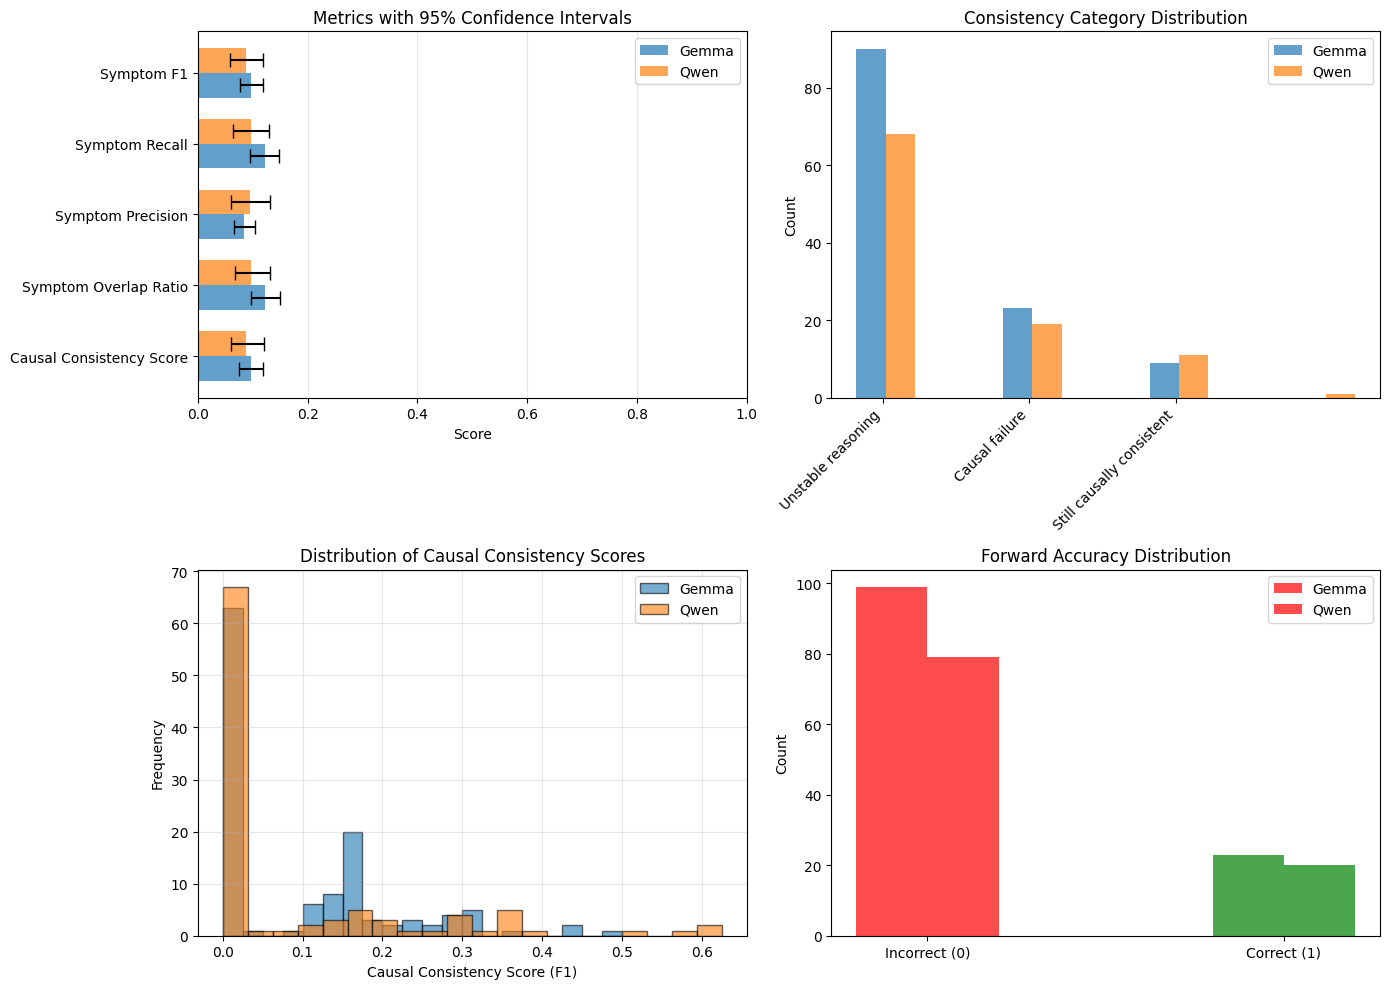

In [46]:
import glob

def analyze_model_results(csv_file, model_name):
    if not os.path.exists(csv_file):
        print(f"Results file not found: {csv_file}")
        return None

    df = pd.read_csv(csv_file)

    print(f"\n{'='*70}")
    print(f"ANALYSIS FOR: {model_name.upper()}")
    print(f"{'='*70}")
    print(f"Total results: {len(df)}")

    def binomial_ci(successes, n, confidence=0.95):
        from scipy.stats import beta
        alpha = 1 - confidence
        lower = beta.ppf(alpha/2, successes, n - successes + 1) if n > successes else 0
        upper = beta.ppf(1 - alpha/2, successes + 1, n - successes) if successes > 0 else 1
        return lower, upper

    def bootstrap_ci(data, statistic_func, n_bootstrap=1000, confidence=0.95):
        n = len(data)
        bootstrap_stats = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=n, replace=True)
            bootstrap_stats.append(statistic_func(sample))
        bootstrap_stats = np.array(bootstrap_stats)
        alpha = 1 - confidence
        lower = np.percentile(bootstrap_stats, 100 * alpha/2)
        upper = np.percentile(bootstrap_stats, 100 * (1 - alpha/2))
        return lower, upper

    results = {
        'model_name': model_name,
        'total_samples': len(df),
        'timestamp': datetime.now().isoformat()
    }

    print(f"\n1. FORWARD ACCURACY (Binary - Binomial Confidence Intervals)")
    print("-" * 70)
    forward_acc = df['forward_accuracy'].values
    n_total = len(forward_acc)
    n_correct = int(np.sum(forward_acc))
    accuracy_mean = np.mean(forward_acc)
    lower_ci, upper_ci = binomial_ci(n_correct, n_total)
    print(f"  Accuracy: {accuracy_mean:.3f}")
    print(f"  95% Confidence Interval: [{lower_ci:.3f}, {upper_ci:.3f}]")
    print(f"  Correct: {n_correct}/{n_total}")

    results['forward_accuracy'] = {
        'mean': float(accuracy_mean),
        'ci_lower': float(lower_ci),
        'ci_upper': float(upper_ci),
        'n_correct': int(n_correct),
        'n_total': int(n_total)
    }

    print(f"\n2. NUMERICAL METRICS (Bootstrap Confidence Intervals)")
    print("-" * 70)

    metrics = {
        'causal_consistency_score': 'Causal Consistency Score (F1)',
        'symptom_overlap_ratio': 'Symptom Overlap Ratio',
        'symptom_precision': 'Symptom Precision',
        'symptom_recall': 'Symptom Recall',
        'symptom_f1': 'Symptom F1'
    }

    results['numerical_metrics'] = {}
    for col_name, metric_name in metrics.items():
        data = df[col_name].dropna().values
        if len(data) > 0:
            mean_val = np.mean(data)
            lower_ci, upper_ci = bootstrap_ci(data, np.mean, n_bootstrap=1000)
            std_val = np.std(data)
            results['numerical_metrics'][col_name] = {
                'mean': float(mean_val),
                'ci_lower': float(lower_ci),
                'ci_upper': float(upper_ci),
                'std': float(std_val),
                'n': int(len(data))
            }
            print(f"  {metric_name}:")
            print(f"    Mean: {mean_val:.3f} (95% CI: [{lower_ci:.3f}, {upper_ci:.3f}])")
            print(f"    Std: {std_val:.3f}, N: {len(data)}")

    print(f"\n3. CONSISTENCY CATEGORY DISTRIBUTION")
    print("-" * 70)
    if 'consistency_category' in df.columns:
        category_counts = df['consistency_category'].value_counts()
        category_props = df['consistency_category'].value_counts(normalize=True)
        results['categories'] = {}
        for category in category_counts.index:
            n = category_counts[category]
            prop = category_props[category]
            lower_ci, upper_ci = binomial_ci(n, n_total)
            results['categories'][category] = {
                'count': int(n),
                'proportion': float(prop),
                'ci_lower': float(lower_ci),
                'ci_upper': float(upper_ci)
            }
            print(f"  {category}: {n} ({prop*100:.1f}%, 95% CI: [{lower_ci:.3f}, {upper_ci:.3f}])")

    print(f"\n4. DISTRIBUTION STATISTICS")
    print("-" * 70)
    print("Causal Consistency Score:")
    desc = df['causal_consistency_score'].describe()
    print(desc)
    results['distribution_stats'] = desc.to_dict()

    return results

csv_files = glob.glob("causal_consistency_results_*.csv")
all_results = {}

if not csv_files:
    print("No results files found. Please run the test first.")
else:
    for csv_file in sorted(csv_files):
        model_name = csv_file.replace("causal_consistency_results_", "").replace(".csv", "")
        results = analyze_model_results(csv_file, model_name)
        if results:
            all_results[model_name] = results

    if len(all_results) > 1:
        print(f"\n{'='*70}")
        print("MODEL COMPARISON")
        print(f"{'='*70}")
        print(f"\nComparing {len(all_results)} models: {', '.join(all_results.keys())}")

        if 'gemma' in all_results and 'qwen' in all_results:
            g = all_results['gemma']
            q = all_results['qwen']

            print(f"\nForward Accuracy:")
            print(f"  Gemma: {g['forward_accuracy']['mean']:.3f} (95% CI: [{g['forward_accuracy']['ci_lower']:.3f}, {g['forward_accuracy']['ci_upper']:.3f}])")
            print(f"  Qwen:  {q['forward_accuracy']['mean']:.3f} (95% CI: [{q['forward_accuracy']['ci_lower']:.3f}, {q['forward_accuracy']['ci_upper']:.3f}])")

            print(f"\nCausal Consistency Score:")
            g_cc = g['numerical_metrics']['causal_consistency_score']
            q_cc = q['numerical_metrics']['causal_consistency_score']
            print(f"  Gemma: {g_cc['mean']:.3f} (95% CI: [{g_cc['ci_lower']:.3f}, {g_cc['ci_upper']:.3f}])")
            print(f"  Qwen:  {q_cc['mean']:.3f} (95% CI: [{q_cc['ci_lower']:.3f}, {q_cc['ci_upper']:.3f}])")

    analysis_file = "analysis_results.json"
    with open(analysis_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    print(f"\n{'='*70}")
    print(f"Analysis results saved to: {analysis_file}")
    print(f"{'='*70}")

    print(f"\n5. VISUALIZATIONS")
    print("-" * 70)

    n_models = len(all_results)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    if n_models > 0:
        metric_names = ['Causal Consistency Score', 'Symptom Overlap Ratio', 'Symptom Precision', 'Symptom Recall', 'Symptom F1']
        x = np.arange(len(metric_names))
        width = 0.35

        for idx, (model_name, results) in enumerate(all_results.items()):
            means = []
            ci_lowers = []
            ci_uppers = []
            metric_keys = ['causal_consistency_score', 'symptom_overlap_ratio', 'symptom_precision', 'symptom_recall', 'symptom_f1']
            for key in metric_keys:
                if key in results['numerical_metrics']:
                    m = results['numerical_metrics'][key]
                    means.append(m['mean'])
                    ci_lowers.append(m['mean'] - m['ci_lower'])
                    ci_uppers.append(m['ci_upper'] - m['mean'])

            offset = (idx - 0.5) * width if n_models > 1 else 0
            ax1.barh(x + offset, means, width, xerr=[ci_lowers, ci_uppers],
                    capsize=5, alpha=0.7, label=model_name.capitalize())

        ax1.set_yticks(x)
        ax1.set_yticklabels(metric_names)
        ax1.set_xlabel('Score')
        ax1.set_title('Metrics with 95% Confidence Intervals')
        ax1.set_xlim(0, 1)
        ax1.grid(axis='x', alpha=0.3)
        if n_models > 1:
            ax1.legend()

    ax2 = axes[0, 1]
    if n_models > 0:
        for idx, (model_name, results) in enumerate(all_results.items()):
            if 'categories' in results:
                category_counts = {k: v['count'] for k, v in results['categories'].items()}
                x_pos = np.arange(len(category_counts))
                offset = (idx - 0.4) * 0.2 if n_models > 1 else 0
                ax2.bar(x_pos + offset, list(category_counts.values()),
                       width=0.2 if n_models > 1 else 0.5, alpha=0.7, label=model_name.capitalize())

        if n_models > 0 and 'categories' in list(all_results.values())[0]:
            ax2.set_xticks(np.arange(len(list(all_results.values())[0]['categories'])))
            ax2.set_xticklabels(list(list(all_results.values())[0]['categories'].keys()), rotation=45, ha='right')
        ax2.set_ylabel('Count')
        ax2.set_title('Consistency Category Distribution')
        if n_models > 1:
            ax2.legend()

    ax3 = axes[1, 0]
    if n_models > 0:
        for model_name, results in all_results.items():
            if os.path.exists(f"causal_consistency_results_{model_name}.csv"):
                df = pd.read_csv(f"causal_consistency_results_{model_name}.csv")
                ax3.hist(df['causal_consistency_score'].dropna(), bins=20, alpha=0.6,
                        label=model_name.capitalize(), edgecolor='black')
        ax3.set_xlabel('Causal Consistency Score (F1)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Causal Consistency Scores')
        ax3.legend()
        ax3.grid(alpha=0.3)

    ax4 = axes[1, 1]
    if n_models > 0:
        for idx, (model_name, results) in enumerate(all_results.items()):
            if 'forward_accuracy' in results:
                acc = results['forward_accuracy']
                labels = ['Incorrect (0)', 'Correct (1)']
                if os.path.exists(f"causal_consistency_results_{model_name}.csv"):
                    df = pd.read_csv(f"causal_consistency_results_{model_name}.csv")
                    counts = df['forward_accuracy'].value_counts().sort_index()
                    x_pos = np.arange(len(labels))
                    offset = (idx - 0.5) * 0.2 if n_models > 1 else 0
                    ax4.bar(x_pos + offset, [counts.get(0, 0), counts.get(1, 0)],
                           width=0.2 if n_models > 1 else 0.5, alpha=0.7,
                           label=model_name.capitalize(), color=['red', 'green'])
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(labels)
        ax4.set_ylabel('Count')
        ax4.set_title('Forward Accuracy Distribution')
        if n_models > 1:
            ax4.legend()

    plt.tight_layout()
    plt.savefig('analysis_visualizations.png', dpi=150, bbox_inches='tight')
    print("Visualizations saved to: analysis_visualizations.png")
    plt.show()

## Flow Explanation

### Test Flow:

1. **Data Loading**: Load the medical symptom dataset from HuggingFace
2. **Forward Pass**:
   - Input: Patient symptoms (from dataset)
   - Process: LLM predicts diagnosis from symptoms
   - Output: Predicted diagnosis
   - Ground Truth: Original diagnosis from dataset
   - Metric: Forward accuracy (does predicted diagnosis match ground truth?)

3. **Backward Pass**:
   - Input: Original diagnosis from dataset (ground truth)
   - Process: LLM predicts symptoms from diagnosis
   - Output: Predicted symptoms
   - Ground Truth: Original symptoms from dataset
   - Metric: Symptom overlap (do predicted symptoms match original symptoms?)

4. **Consistency Evaluation**:
   - Compare predicted symptoms (from backward pass) with original symptoms (from forward pass)
   - Calculate: Precision, Recall, F1 score
   - **Causal Consistency Score = F1 score** (measures bidirectional coherence)

### How Ground Truth is Used:

- **Original Symptoms**: Used as ground truth to evaluate the backward pass
- **Original Diagnosis**: Used as ground truth to evaluate the forward pass AND as input to the backward pass
- **Consistency Check**: Verifies that the model's reasoning is bidirectional - if symptoms A → diagnosis B, then diagnosis B → symptoms A should be consistent

### Expected Behavior of a Faithful Model:

A faithful model should:
- Correctly predict diagnosis from symptoms (high forward accuracy)
- Correctly predict symptoms from diagnosis (high backward accuracy)  
- Maintain consistency: symptoms predicted in backward pass should match original symptoms (high causal consistency score)

If the model is inconsistent (low F1 score), it suggests the model's reasoning may not be based on stable causal relationships between symptoms and diagnoses.
